# Modeling the energy production and consumption

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import keras
from keras.models import Sequential
from keras.layers import Dense, Input

import tensorflow as tf
tf.keras.utils.set_random_seed(1234)

2024-01-17 19:25:07.356731: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-17 19:25:07.396948: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 19:25:07.396980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 19:25:07.398123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 19:25:07.404322: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-17 19:25:07.404889: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
df = pd.read_csv("data_clean.csv")

In [3]:
df

,is_consumption,eic_count,installed_capacity,day,weekday,month,year,sin(dayofyear),cos(dayofyear),sin(hour),...,snowfall_fl,total_precipitation_fl,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target
0,0,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.000000,...,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.000000,...,0.0,0.0,139.453,58.607,52.032,146.872,126.820,125.237,115.243,137.370
2,0,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.258819,...,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.258819,...,0.0,0.0,170.381,59.506,45.385,143.722,127.469,119.205,125.407,131.906
4,0,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.500000,...,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29883,1,17.0,540.0,31,3,5,2023,0.522133,-0.852864,-0.707107,...,0.0,0.0,136.592,65.207,63.559,153.743,129.940,113.642,126.078,132.470
29884,0,17.0,540.0,31,3,5,2023,0.522133,-0.852864,-0.500000,...,0.0,0.0,0.000,0.005,0.002,0.005,0.004,0.003,0.000,0.002
29885,1,17.0,540.0,31,3,5,2023,0.522133,-0.852864,-0.500000,...,0.0,0.0,121.699,75.828,69.059,117.201,113.768,93.736,123.870,114.667
29886,0,17.0,540.0,31,3,5,2023,0.522133,-0.852864,-0.258819,...,0.0,0.0,0.002,0.002,0.005,0.003,0.000,0.004,0.000,0.000


In [4]:
df.columns

Index(['is_consumption', 'eic_count', 'installed_capacity', 'day', 'weekday',
       'month', 'year', 'sin(dayofyear)', 'cos(dayofyear)', 'sin(hour)',
       'cos(hour)', 'temperature', 'dewpoint', 'cloudcover_high',
       'cloudcover_low', 'cloudcover_mid', 'cloudcover_total',
       '10_metre_u_wind_component', '10_metre_v_wind_component',
       'direct_solar_radiation', 'surface_solar_radiation_downwards',
       'snowfall', 'total_precipitation', 'surface_pressure', 'rain',
       'windspeed_10m', 'winddirection_10m', 'shortwave_radiation',
       'diffuse_radiation', 'temperature_fl', 'dewpoint_fl',
       'cloudcover_high_fl', 'cloudcover_low_fl', 'cloudcover_mid_fl',
       'cloudcover_total_fl', '10_metre_u_wind_component_fl',
       '10_metre_v_wind_component_fl', 'direct_solar_radiation_fl',
       'surface_solar_radiation_downwards_fl', 'snowfall_fl',
       'total_precipitation_fl', 'target_1', 'target_2', 'target_3',
       'target_4', 'target_5', 'target_6', 'target_7',

In [5]:
features = [
    'eic_count',
    'installed_capacity',
    'day',
    'weekday',
    'month',
    'year',
    'sin(dayofyear)',
    'cos(dayofyear)',
    'sin(hour)',
    'cos(hour)',
    
    # weaher
    'temperature',
    'dewpoint',
    'cloudcover_high',
    'cloudcover_low',
    'cloudcover_mid',
    'cloudcover_total',
    '10_metre_u_wind_component',
    '10_metre_v_wind_component',
    'direct_solar_radiation',
    'surface_solar_radiation_downwards',
    'snowfall',
    'total_precipitation',
    'surface_pressure',
    'rain',
    'windspeed_10m',
    'winddirection_10m',
    'shortwave_radiation',
    'diffuse_radiation',
    
    # forecast
    'temperature_fl',
    'dewpoint_fl',
    'cloudcover_high_fl',
    'cloudcover_low_fl',
    'cloudcover_mid_fl',
    'cloudcover_total_fl',
    '10_metre_u_wind_component_fl',
    '10_metre_v_wind_component_fl',
    'direct_solar_radiation_fl',
    'surface_solar_radiation_downwards_fl',
    'snowfall_fl',
    'total_precipitation_fl',

    # lags of energy production
    'target_1',
    'target_2',
    'target_3',
    'target_4',
    'target_5',
    'target_6',
    'target_7'
]

### Energy production modeling

In [6]:
df_production = df.loc[df.is_consumption==0].drop(columns="is_consumption").reset_index(drop=True)

In [7]:
df_production

,eic_count,installed_capacity,day,weekday,month,year,sin(dayofyear),cos(dayofyear),sin(hour),cos(hour),...,snowfall_fl,total_precipitation_fl,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target
0,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.000000,1.000000,...,0.0,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.258819,0.965926,...,0.0,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.500000,0.866025,...,0.0,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.707107,0.707107,...,0.0,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.866025,0.500000,...,0.0,8.940697e-08,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14939,17.0,540.0,31,3,5,2023,0.522133,-0.852864,-0.965926,0.258819,...,0.0,0.000000e+00,10.605,14.375,25.598,9.822,7.201,7.283,10.316,9.685
14940,17.0,540.0,31,3,5,2023,0.522133,-0.852864,-0.866025,0.500000,...,0.0,0.000000e+00,4.253,7.447,7.501,2.767,3.239,1.926,3.897,3.365
14941,17.0,540.0,31,3,5,2023,0.522133,-0.852864,-0.707107,0.707107,...,0.0,0.000000e+00,0.187,0.859,1.011,0.396,0.061,0.113,0.170,0.379
14942,17.0,540.0,31,3,5,2023,0.522133,-0.852864,-0.500000,0.866025,...,0.0,0.000000e+00,0.000,0.005,0.002,0.005,0.004,0.003,0.000,0.002


In [8]:
def split__train_val_test_sets(df):
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)
    
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = df_train.target.values
    y_val = df_val.target.values
    y_test = df_test.target.values
    
    del df_train['target']
    del df_val['target']
    del df_test['target']
    return df_train, df_test, df_val, y_train, y_test, y_val

In [9]:
df_train, df_test, df_val, y_train, y_test, y_val = split__train_val_test_sets(df_production)

In [10]:
df_train

,eic_count,installed_capacity,day,weekday,month,year,sin(dayofyear),cos(dayofyear),sin(hour),cos(hour),...,surface_solar_radiation_downwards_fl,snowfall_fl,total_precipitation_fl,target_1,target_2,target_3,target_4,target_5,target_6,target_7
0,18.0,645.2,27,2,12,2022,-0.085731,0.996318,-5.000000e-01,-0.866025,...,26.905348,0.000000,2.187490e-05,0.878,2.871,0.268,0.040,0.042,0.010,0.000
1,6.0,324.2,23,7,1,2022,0.384665,0.923056,7.071068e-01,0.707107,...,0.000000,0.000000,0.000000e+00,0.000,0.000,0.000,0.000,0.004,0.001,0.000
2,15.0,505.2,14,5,10,2022,-0.977064,0.212947,-7.071068e-01,0.707107,...,0.000000,0.000000,2.933741e-04,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,18.0,645.2,30,3,11,2022,-0.522133,0.852864,-5.000000e-01,0.866025,...,0.000000,0.000002,-1.830631e-08,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,16.0,572.2,7,5,4,2023,0.995546,-0.094279,-5.000000e-01,-0.866025,...,584.159200,0.000000,0.000000e+00,3.897,45.460,46.464,82.348,99.091,14.645,8.082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8961,6.0,330.2,17,2,5,2022,0.710135,-0.704066,-8.660254e-01,-0.500000,...,339.671100,0.000000,5.960465e-07,53.507,6.028,40.570,7.489,40.749,36.090,34.097
8962,15.0,505.2,19,3,10,2022,-0.955211,0.295927,9.659258e-01,-0.258819,...,0.000000,0.000000,0.000000e+00,0.000,0.000,0.000,0.001,0.000,0.003,0.001
8963,6.0,324.2,8,2,2,2022,0.620609,0.784120,1.224647e-16,-1.000000,...,157.455550,0.000010,1.368353e-05,0.575,0.623,0.036,0.116,0.280,0.089,10.318
8964,16.0,569.7,30,4,3,2023,0.999079,0.042905,9.659258e-01,0.258819,...,0.000000,0.000012,8.165836e-06,0.005,0.006,0.007,0.004,0.006,0.006,0.004


In [11]:
X_train = df_train[features]
X_val = df_val[features]
X_test = df_test[features]

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
print(scaler.mean_)

[1.12484943e+01 4.68307707e+02 1.58914789e+01 3.96988624e+00
 6.40932411e+00 2.02206737e+03 4.82427096e-02 1.35266690e-01
 1.47651255e-03 7.65782531e-03 5.55454437e+00 2.22415662e+00
 3.94162010e-01 4.33270385e-01 3.58108784e-01 6.80982845e-01
 1.13611528e+00 7.32562933e-01 1.49169505e+02 1.08997982e+02
 2.63616824e-05 8.03756845e-05 1.00914262e+03 5.07158991e-02
 4.87848251e+00 1.96625779e+02 1.04628225e+02 4.11945515e+01
 5.61623975e+00 2.04651246e+00 3.97875007e-01 4.21758251e-01
 3.45672100e-01 6.72226674e-01 7.75882042e-01 6.04910210e-01
 1.51848428e+02 1.09429850e+02 2.37022894e-05 7.93497275e-05
 9.96768938e+00 9.68639616e+00 9.54436861e+00 9.53862670e+00
 9.36637910e+00 9.45271838e+00 9.11415113e+00]


In [13]:
X_train_scaled = scaler.transform(X_train)

### Neural Network

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

In [16]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, input_dim=64, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='relu'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='mean_squared_error', 
        metrics=['mse'])
    return model

model = get_model(X_train_scaled.shape[1], 1)

2024-01-17 19:27:10.067665: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3072      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5185 (20.25 KB)
Trainable params: 5185 (20.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
history = model.fit(
    X_train_scaled,
    y_train,
    batch_size=1024,
    epochs=100,
    validation_data=(X_train_scaled, y_train)
)

Epoch 1/100
9/9 [==============================] - 1s 28ms/step - loss: 698.8102 - mse: 698.8102 - val_loss: 686.7264 - val_mse: 686.7264
Epoch 2/100
9/9 [==============================] - 0s 8ms/step - loss: 660.9706 - mse: 660.9706 - val_loss: 619.2862 - val_mse: 619.2862
Epoch 3/100
9/9 [==============================] - 0s 7ms/step - loss: 582.3826 - mse: 582.3826 - val_loss: 529.6631 - val_mse: 529.6631
Epoch 4/100
9/9 [==============================] - 0s 7ms/step - loss: 487.2803 - mse: 487.2803 - val_loss: 429.8203 - val_mse: 429.8203
Epoch 5/100
9/9 [==============================] - 0s 7ms/step - loss: 384.3061 - mse: 384.3061 - val_loss: 323.6135 - val_mse: 323.6135
Epoch 6/100
9/9 [==============================] - 0s 7ms/step - loss: 280.5665 - mse: 280.5665 - val_loss: 228.0350 - val_mse: 228.0350
Epoch 7/100
9/9 [==============================] - 0s 8ms/step - loss: 195.8349 - mse: 195.8349 - val_loss: 164.9713 - val_mse: 164.9713
Epoch 8/100
9/9 [=======================

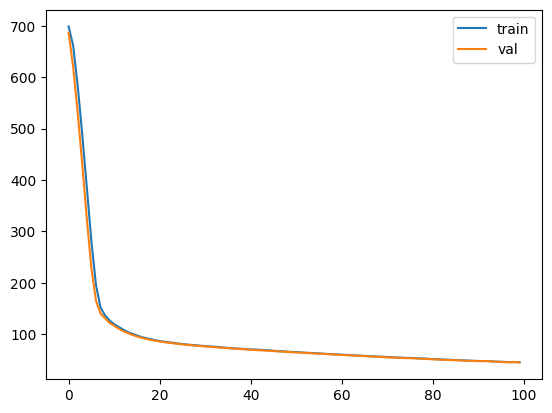

In [19]:
plt.plot(history.history['mse'], label='train');
plt.plot(history.history['val_mse'], label='val');
plt.title('MSE of training and validation for each epoch');
plt.legend();

### Test

In [20]:
X_test_scaled = scaler.transform(X_test)

In [21]:
predictions = model.predict(X_test_scaled)

94/94 [==============================] - 0s 1ms/step


In [22]:
def add_predictions(df,predictions):
    df["prediction"] = predictions
    return df

In [23]:
predictions

array([[ 0.      ],
       [53.34238 ],
       [16.435179],
       ...,
       [ 0.      ],
       [ 0.      ],
       [ 0.      ]], dtype=float32)

In [24]:
y_pred = predictions.reshape(-1)

In [25]:
rng = np.random.RandomState(10)
a = np.hstack((rng.normal(size=1000),
               rng.normal(loc=5, scale=2, size=1000)))

In [26]:
a

array([ 1.3315865 ,  0.71527897, -1.54540029, ...,  5.74446677,
        6.22449239,  8.42055014])

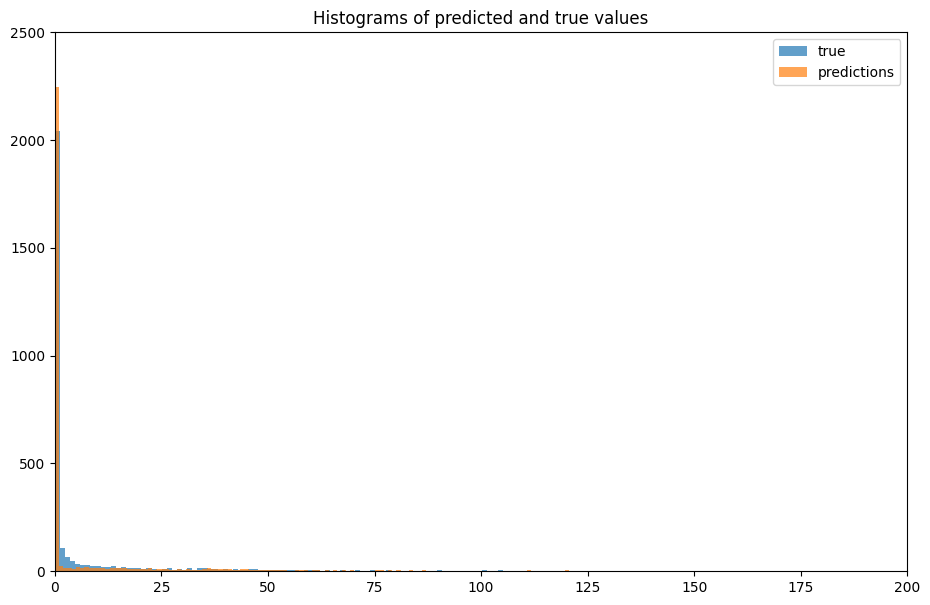

In [27]:
plt.figure(figsize=(11,7))
_ = plt.hist(y_test, bins=200, alpha=0.7, label="true")  # arguments are passed to np.histogram
_ = plt.hist(y_pred, bins=200, alpha=0.7, label="predictions")  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
# plt.show()
plt.title("Histograms of predicted and true values")
plt.xlim([0, 200])
plt.ylim([0, 2500])
plt.legend()
plt.show()

In [28]:
y_pred.max()

197.83063

In [29]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_pred, y_test)
mse

63.27871619784743

In [30]:
y_test.mean()

10.297117096018734

In [31]:
y_pred.mean()

9.473367

## Adjusting the learning rate

https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/08-deep-learning/notebook.ipynb

In [34]:
def get_model(n_inputs, n_outputs, learning_rate=0.01):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, input_dim=64, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='relu'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=['mse'])
    return model

In [44]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = get_model(X_train_scaled.shape[1], 1, learning_rate=lr)
    history = model.fit(
        X_train_scaled,
        y_train,
        batch_size=1024,
        epochs=200,
        validation_data=(X_train_scaled, y_train),
        verbose=0
    )
    scores[lr] = history.history

    print()
    print()

0.0001


0.001


0.01


0.1




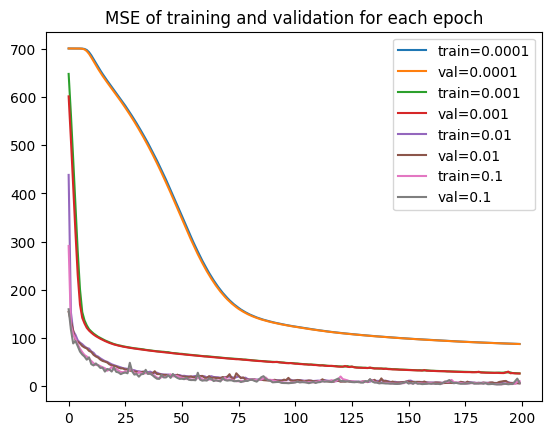

In [46]:
for lr, hist in scores.items():
    plt.plot(hist['mse'], label=('train=%s' % lr));
    plt.plot(hist['val_mse'], label=('val=%s' % lr));
plt.title('MSE of training and validation for each epoch');
plt.legend();

#### Summary
- Learning rates of 0.0001 and 0.001 make the model learn too slow.
- Learning rates of 0.01 and 0.1 give similar results however with 0.1 values are not smooth.
- The best value of **learning rate** for our model: **0.01**.

### Tuning the size of an inner layer

In [47]:
def get_model(n_inputs, n_outputs, learning_rate=0.01, size=32):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(size, input_dim=64, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='relu'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=['mse'])
    return model

In [55]:
scores = {}
lr = 0.01

for s in [16, 32, 64, 128, 256]:
    print(s)

    model = get_model(X_train_scaled.shape[1], 1, learning_rate=lr, size=s)
    history = model.fit(
        X_train_scaled,
        y_train,
        batch_size=1024,
        epochs=200,
        validation_data=(X_train_scaled, y_train),
        verbose=0
    )
    scores[s] = history.history

    print()
    print()

16


32


64


128


256




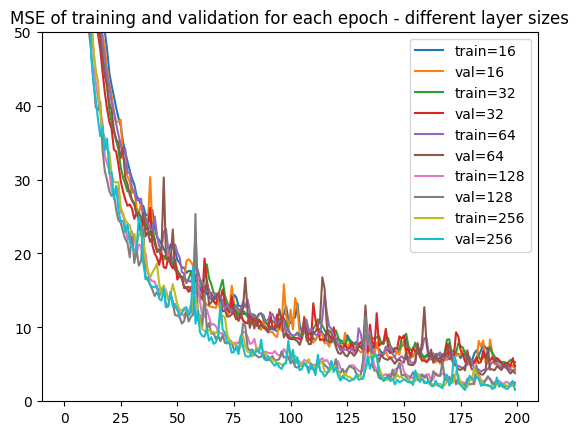

In [56]:
for s, hist in scores.items():
    plt.plot(hist['mse'], label=('train=%s' % s));
    plt.plot(hist['val_mse'], label=('val=%s' % s));
plt.title('MSE of training and validation for each epoch - different layer sizes');
plt.ylim([0,50]);
plt.legend();

#### Summary
- The larger the layer the lower the MSE for training and validation sets.
- However, the difference between 128 and 256 doesn't seem to be significant.
- We choose **size-128** to keep the model as simple as possible.